Some code adapted from: 

---

https://stackoverflow.com/questions/56719138/how-can-i-save-a-librosa-spectrogram-plot-as-a-specific-sized-image
user: jonnor

---

and from:
https://towardsdatascience.com/getting-to-know-the-mel-spectrogram-31bca3e2d9d0
by Dalya Gartzman

The Mel Spectrogram uses a frequency scale which matches the human ear in emphasizing the frequencies which are important for differentiating sounds.

In [0]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from scipy.io import wavfile
from PIL import Image
import os
import librosa
import librosa.display
from skimage import io
from skimage.transform import resize

mainDataFolder = "/content/drive/My Drive/ColabData"
melSpectrogramFolder = mainDataFolder + "/Mel Spectrograms"

def scale_minmax(X, min=0.0, max=1.0):
  X_std = (X - X.min()) / (X.max() - X.min())
  X_scaled = X_std * (max - min) + min
  return X_scaled

def GenerateMelSpectrogram(source, destination):
  resolution = 128
  audioFile, sr = librosa.load(source)
  S = librosa.feature.melspectrogram(audioFile, sr=sr, n_fft=2048, 
                                   hop_length=512, 
                                   n_mels=128)
  mels = np.log(S + 1e-9) # add small number to avoid log(0)
  # min-max scale to fit inside 8-bit range
  img = scale_minmax(mels, 0, 255).astype(np.uint8)
  # put low frequencies at the bottom in image
  img = np.flip(img, axis=0)
  # save as PNG
  outputFile = destination + "/" + (source[source.rfind("/")+1:source.rfind(".")]) + ".png"
  io.imsave(outputFile, img)
  #use pillow to resize the image 
  image  = Image.open(outputFile)  
  width, height = image.size 
  image = image.crop((0,0,height,height))
  image = image.resize((resolution,resolution),1) # resize using best interpolation
  image.save(outputFile)

In [0]:

from IPython.display import clear_output
def MelSpectrogramsFromDirectory(sourceFolder):
  n = 0
  totalFiles = len(os.listdir(sourceFolder))

  for filename in os.listdir(sourceFolder):
      if filename.endswith(".wav"):
        #Save instruments and synth to seperate folders
          destination  = melSpectrogramFolder + ("/Synth" if "Synth" in filename else "/Inst")
          GenerateMelSpectrogram(sourceFolder + "/" + filename, destination)
          clear_output()
          print(indexof(fileName) + "/" + totalFiles)

In [0]:
#Generate mel spectrograms for each folder
#MelSpectrogramsFromDirectory(mainDataFolder + "/Inst")
#MelSpectrogramsFromDirectory(mainDataFolder + "/Synth")

Color channels: 1


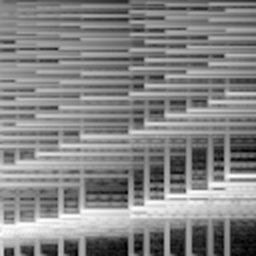

In [0]:
testImage = melSpectrogramFolder + "/Synth/Synth2 (180).png"
#number of channels in a mel spectrogram shound be one
testImage = Image.open(testImage)
print("Color channels: " + str(len(testImage.getbands())))
testImage.resize((256,256),1)

In [0]:
#Get the number of images of each type in the set
print("Instrument Spectrograms: " + str(len(os.listdir(melSpectrogramFolder + "/Inst"))))
print("Synth Spectrograms: " + str(len(os.listdir(melSpectrogramFolder + "/Synth"))))

Instrument Spectrograms: 549
Synth Spectrograms: 513


In [0]:
#generate list of every file

fileList = []
for f in os.listdir(melSpectrogramFolder + "/Synth/"):
  fileList.append(melSpectrogramFolder + "/Synth/" + f)
for f in os.listdir(melSpectrogramFolder + "/Inst/"):
   fileList.append(melSpectrogramFolder + "/Inst/" + f)

print(len(fileList))


1062


This builds the dataset from the images.

In [0]:
#Lables: 0 is synth, 1 is instrument
import tensorflow as tf 
from IPython.display import clear_output

dataSet = []

percentage = 0
instCount = 0

#to use a reduced set, modify here
dataList = fileList

percent  = 0
instCount = 0

for f in dataList:
  classLable = 0 if ("Synth" in f or "Synth2" in f) else 1
  if classLable == 1: instCount += 1
  img = Image.open(f)
  img = tf.keras.preprocessing.image.img_to_array(img)
  dataSet.append([img,classLable])
  #see progress as a percentage
  p = int(100.0 * float(dataList.index(f)) / len(dataList)) 
  if percent != p:
    clear_output()
    s = str(p)
    print(s[:min(len(s),2)] + "%")
    percent = p

print("Instrument Samples: " + str(instCount))
print("Synth Samples: " + str(len(dataList) - instCount))
    
    

99%
Instrument Samples: 549
Synth Samples: 513


In [0]:
#save the np array to reuse
np.save(mainDataFolder + "/Dataset/dataset2",dataSet,allow_pickle=True)